Backlog prioritization leads to the choice between strategies. Each one has its metrics. There is a requirement to choose the most efficient one. ML scoring is a solution when nonlinearity exists and economy is nonlinear. See https://habr.com/en/users/sergkremen1984/posts/. In this example two groups are considered. First (I) corresponds to web conversion {bounce rate, micro conversion, time, depth}. Second (II) corresponds to attraction of new visitors from organic channel {visits, viewers, views}. The target function is a number of commercial offers per day. CJM can be represented in the following way {Web}=>{Contacts Page}=>{Call}=>{Advisory Department}=>{Call}=>{Sales department}. The task is to reduce the dimension to get the optimal strategy. Calls are tracked manually in CRM, but online/offline B2B channels can't be seperated: market is thin and new customers may have some information about 'the brand' from offline/online channels. Statistical evaluation is closer to reality than CJM tracking.  

Import external libraries:

In [100]:

#core#
import numpy as np 
from numpy import linspace, loadtxt, ones, convolve
from numpy import set_printoptions
import pandas as pd 
from pandas import set_option
from operator import add
import dateutil.parser
#/core#

#basic statistics#
from statistics import median 
from statistics import mean 
from statistics import stdev
import statsmodels.api as sm
from math import log
#/basic statistics#

#charts#
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
from numpy.polynomial.polynomial import polyfit
#/charts#

#out-of-sample test#
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
#/out-of-sample test#

#unsupervised learning#
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#/unsupervised learning#

#supervised learning#
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
#/supervised learning#

Define custom functions:

In [101]:
def normal(x): #normalize to (0,1) interval
    z=(x-x.min())/(x.max()-x.min())
    return z

def cormap(x): #correlation map
  corr=x.corr();fig=plt.figure(figsize=(10, 7))
  g=sns.heatmap(corr,annot=True,linewidths=.2, cbar_kws={"orientation": "horizontal"})
  plt.show()
    
def get_class(x,y):
    class_type=[]
    for item in list(x):
        if 0<=item<y:   class_type.append(0) #1 class  
        if y<=item<=1:  class_type.append(1) #2 class
    return class_type

def pca(x,y):
  pca=PCA()
  pca.fit(y)
  PCA(copy=True)
  
  features=x;pca.explained_variance_=normal(pca.explained_variance_)
  pca.explained_variance_=list(np.array(pca.explained_variance_)*100)
  plt.bar(x, pca.explained_variance_,width=0.5)
  plt.xticks(features)
  plt.ylabel('variance')
  plt.xlabel('PCA feature')
  print('\nComponent importance:')
  
  for i in range(0,len(pca.explained_variance_)):
    print(str(x[i])+': '+str(int(pca.explained_variance_[i]))+'%')
    i=i+1
  
  plt.show()

Parameters:

In [102]:
split_num=10 #initial number of cross validation folds

Read data from files with crm and web data, parsed by webparse script from web analytics platform API.   

In [103]:
df_web_all=pd.read_excel('DATA_NEW/TRAFFIC.xlsx') #general web sessions/metrics per day
df_web_cr=pd.read_excel('DATA_NEW/WEB_CR.xlsx') #converted web sessions/metrics per day
df_crm=pd.read_excel('DATA_NEW/OFF_CR.xlsx') #crm commercial offers per day

Drop useless columns from df_web_cr and df_web_all

In [104]:
df_web_cr.drop(df_web_cr.columns[2:],axis=1,inplace=True)
df_web_cr['Visits_CR']=df_web_cr['Visits'];del df_web_cr['Visits'];

Merging of dataframes

In [105]:
df=df_web_all.merge(df_web_cr,how='inner',left_on='Date',right_on='Date') #inner join of web metrics and conversion metrics

Add conversion rate column:

In [106]:
df['CR,%']=round(100*df['Visits_CR']/df['Visits']);del df['Visits_CR'] #web conversion
df=df[['Date','Visits','Viewers','Views','BR','Depth','Time','CR,%']] #replace columns
print(df.head())

        Date  Visits  Viewers  Views    BR  Depth    Time   CR,%
0 2015-05-05       8        8     32   0.0    4.0  110.75   50.0
1 2015-05-06       7        7     14   0.0    2.0  101.00   29.0
2 2015-05-07       5        5      8  20.0    1.6   42.80   20.0
3 2015-05-09       1        1      3   0.0    3.0  214.00  100.0
4 2015-05-12       4        4      6   0.0    1.5    9.75   25.0


Merging with crm dataframe - number of commersial offers per day

In [107]:
df=df.merge(df_crm,how='left',left_on='Date',right_on='Date') #inner join with crm data - offers per day and date
df['Offers']=df['Offers'].fillna(0) #fill na with nulls

Show column names, dates, volume

In [108]:
column_names=list(df.columns.values)
print('All fields:',column_names)

print('Data Start:',list(df['Date'])[0])
print('Data End:',list(df['Date'])[-1])

print('Number of records:', len(df))

All fields: ['Date', 'Visits', 'Viewers', 'Views', 'BR', 'Depth', 'Time', 'CR,%', 'Offers']
Data Start: 2015-05-05 00:00:00
Data End: 2019-06-22 00:00:00
Number of records: 1338


Normalize features to the 0,1 interval except date:

In [109]:
date_list=list(df['Date']);del df['Date'] #create date list  

for item in ['Visits','Viewers','Views','BR','Time','CR,%','Offers']: 
    df[item]=normal(df[item])         

Make correlation map:

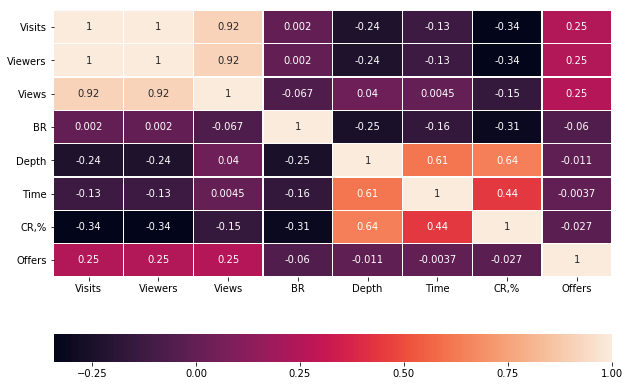

In [110]:
cormap(df)

Two "warm" regions represent suggested groups of metrics. Offers vs Visits mapping represents highest correlation. Let's do some statistical inference and boxplot without outliers. 

Common description:
count    1338.000000
mean        0.144648
std         0.175323
min         0.000000
25%         0.000000
50%         0.038462
75%         0.269231
max         1.000000
Name: Offers, dtype: float64


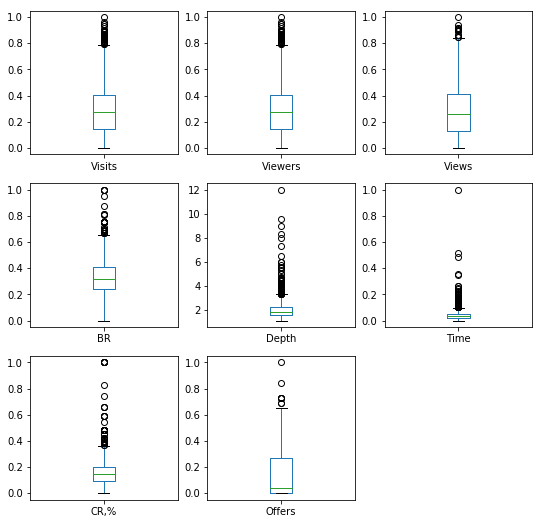

Skew of Offers: 1.02


In [111]:
description=df['Offers'].describe()
print('Common description:')
print(description)

df.plot(kind='box',subplots=True,layout=(3,3),sharex=False,sharey=False,figsize=(9,9))
plt.show()

skew=df['Offers'].skew()
print('Skew of Offers:',round(skew,2))

Binning of target: in general case we may use equal splits for 2 classes: {typical behaviour and outliers}. We tend to understand what factor may cause qualitative change. 

In [112]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['Offers'],0.5)
del df_binary['Offers']

Let's make an estimation of feature importance based on principal component analysis. 


Component importance:
Visits: 100%
Viewers: 16%
Views: 3%
BR: 0%
Depth: 0%
Time: 0%
CR,%: 0%


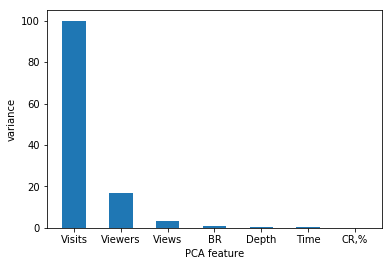

In [113]:
df_pca=df_binary.copy();del df_pca['Offers_BIN'] 
column_names=df_pca.columns
pca(column_names,df_pca)

Visits give higher input according to PCA. It confirms the weak correlation of Visits vs Offers. However Visits represent high correlation with Views and Viewers. Recursive feature elimination (RFE) with Logistic Regression:

In [114]:
array=df_binary.values
X=array[:,0:7];Y=array[:,7]

print("\nLogisticRegression:")
print("Column names:",list(column_names))
model=LogisticRegression(solver='liblinear')
selector=RFECV(model,1,cv=split_num)
selector=selector.fit(X,Y)
print("Feature Ranking: %s" % selector.ranking_)


LogisticRegression:
Column names: ['Visits', 'Viewers', 'Views', 'BR', 'Depth', 'Time', 'CR,%']
Feature Ranking: [5 1 3 2 4 7 6]


'Visits' metric has a higher impact. Let's test the feature importance by chi2 test:

In [115]:
test = SelectKBest(score_func=chi2, k=1)
fit = test.fit(X, Y)
set_printoptions(precision=2)
print("Features:",list(column_names))
print("Importance:",fit.scores_)

Features: ['Visits', 'Viewers', 'Views', 'BR', 'Depth', 'Time', 'CR,%']
Importance: [3.3  3.3  2.39 0.04 0.73 0.04 0.27]


Importance of visits/viwers/views is confirmed. Let's test all features in several supervised learning models. First we compare several algos. We included linear /high bias/ and nonlinear /high variance/ models here. 

gb: 0.946903 (0.036274)
sv: 0.953653 (0.035182)
lg: 0.953653 (0.035182)
nb: 0.839614 (0.183761)
dt: 0.887078 (0.044209)
knn: 0.951403 (0.035583)

Scattering of models accuracy: 0.11


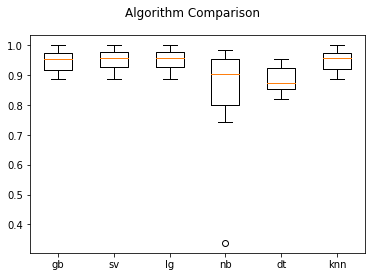

In [116]:
models=[]
models.append(('gb',GradientBoostingClassifier(n_estimators=100,random_state=7)))
models.append(('sv',SVC(gamma='auto')))
models.append(('lg',LogisticRegression(solver='liblinear')))
models.append(('nb',GaussianNB()))
models.append(('dt',DecisionTreeClassifier()))
models.append(('knn',KNeighborsClassifier()))

results=[]
names=[]
scattering=[]
scoring='accuracy'

for name, model in models:
  kfold = KFold(n_splits=split_num, random_state=7)
  cv_results=cross_val_score(model,X,Y,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg="%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  scattering.append(cv_results.mean())
  print(msg)

maxmin_delta=(max(scattering)-min(scattering))
print('\nScattering of models accuracy:',round(maxmin_delta,2))

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Models are comparable in relation to accuracy/scattering. Let's test all features in the ensemble voting.

In [117]:
#building the ensemble#
gb=GradientBoostingClassifier(n_estimators=100,random_state=7)
sv=SVC(gamma='auto')
lg=LogisticRegression(solver='liblinear')
nb=GaussianNB()
dt=DecisionTreeClassifier()
knn=KNeighborsClassifier()

estimators=[]
estimators.extend([('gb',gb),('sv',sv),('lg',lg),('nb',nb),('dt',dt),('knn',knn)])
ensemble=VotingClassifier(estimators)
#/building the ensemble#
   
#output of results#
kfold=KFold(n_splits=split_num,random_state=7)
results=cross_val_score(ensemble,X,Y,cv=kfold)

print('\nAverage score:'+str(round(100*median(results)))+str('%'))
print('Standard deviation of score:'+str(round(100*stdev (results)))+str('%'))
#/output of results#


Average score:96.0%
Standard deviation of score:4%


We experiment with N combinations to get a single feature which gives the minimal accuracy drawdown. The result is validated by PCA, chi2 test. We may consider the number of organic sessions only (!). In this very case the SEO campaign is cheaper than CRO. So, it's ok for biz. Let's look how algos work after the reduction:

gb: 0.947638 (0.035738)
sv: 0.953653 (0.035182)
lg: 0.953653 (0.035182)
nb: 0.948390 (0.035166)
dt: 0.947638 (0.035738)
knn: 0.951397 (0.034296)

Scattering of models accuracy: 0.01


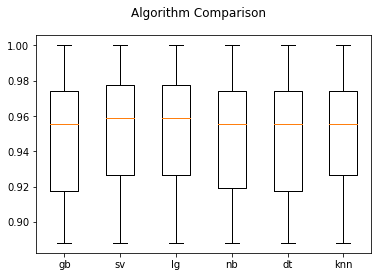

In [118]:
array=df_binary.values
X=array[:,0:1];Y=array[:,7]

results=[]
names=[]
scattering=[]
scoring='accuracy'

for name, model in models:
  kfold = KFold(n_splits=split_num, random_state=7)
  cv_results=cross_val_score(model,X,Y,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg="%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  scattering.append(cv_results.mean())
  print(msg)

maxmin_delta=(max(scattering)-min(scattering))
print('\nScattering of models accuracy:',round(maxmin_delta,2))

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Smaller scattering means that we get more stable model. Let's estimate its perfomance.

In [119]:
#output of results#
results=cross_val_score(ensemble,X,Y,cv=kfold)

print('\nAverage score:'+str(round(100*median(results)))+str('%'))
print('Standard deviation of score:'+str(round(100*stdev (results)))+str('%'))
#/output of results#


Average score:96.0%
Standard deviation of score:4%


Conclusion: no additional information is given by other features. Traffic has highest importance for prediction and corresponds to  more stable prediction model. The proposed method may be generalized in decision making when nonlinearity is inevitable. 